In [1]:
import csv
import warnings
from functools import lru_cache
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, update_display, Pretty, clear_output
from sklearn import svm, metrics, datasets
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils import shuffle
from sklearn.linear_model import Perceptron
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split


# Ignore annoying warning for non-convergence in scikit
def warn(*args, **kwargs):
    pass


warnings.warn = warn

## Data Loading
use lru_cache decorator to cache load_svmlight_file() calls.

In [10]:
@lru_cache
def load_data(pathname):
    return load_svmlight_file(pathname)


@lru_cache
def load_imdb(filename):
    lines = [l.strip().split() for l in open(filename)]

    # funcs to make features and classes binary
    featfunc = lambda x: 1 if x > 0 else 0
    classfunc = lambda x: 1 if x > 4 else 0

    # parse data
    X, y = [], []
    for l in lines[1:]:
        # class
        y.append(classfunc(int(l.pop(0))))

        # features
        feats = [ft.split(":") for ft in l]
        X.append({int(i): featfunc(int(v)) for i, v in feats})

    return X, y

## The Perceptron

In [3]:
class AddingPerceptron:
    def __init__(self, testData, trainData, dataset_name, vectorize=False):
        self.accuracies = {"normal": [0], "proportional": [0]}
        self.epochs = 0

        # track dataset info
        self.dataset_name = dataset_name
        self.train_size = len(trainData[1])
        self.test_size = len(testData[1])

        # format data
        if vectorize:
            vectorizer = DictVectorizer()
            self.X = vectorizer.fit_transform(trainData[0])
            self.y = trainData[1]
            self.test_X = vectorizer.transform(testData[0])
            self.test_y = testData[1]
        else:
            self.X, self.y = trainData
            self.test_X, self.test_y = testData

    def test(self, epochs):
        self.accuracies = {"normal": [], "proportional": []}
        self.epochs = epochs

        # accuracy display
        msg = Pretty(data="")
        display(msg, display_id="msg")

        # init base perceptrons
        summed = Perceptron(max_iter=1)
        summed.fit(self.X, self.y)
        summed_prop = Perceptron(max_iter=1)
        summed_prop.fit(self.X, self.y)

        for i in range(epochs):
            X, y = shuffle(self.X, self.y)

            # train a new perceptron for one epoch
            fresh_model = Perceptron(max_iter=1, random_state=i)
            fresh_model.fit(X, y)

            # update summed model
            summed.coef_ = summed.coef_ + fresh_model.coef_
            summed.intercept_ = summed.intercept_ + fresh_model.intercept_

            # update summed proportional model
            fresh_acc = metrics.accuracy_score(y, fresh_model.predict(X))
            summed_prop.coef_ = summed_prop.coef_ + (fresh_model.coef_ * fresh_acc)
            summed_prop.intercept_ = summed_prop.intercept_ + (fresh_model.intercept_ * fresh_acc)

            # get accuracy scores
            normalAcc = metrics.accuracy_score(self.test_y, summed.predict(self.test_X))
            propAcc = metrics.accuracy_score(self.test_y, summed_prop.predict(self.test_X))

            # record
            self.accuracies["normal"].append(normalAcc)
            self.accuracies["proportional"].append(propAcc)

            # update text
            msg.data = (
                f"Adding: {normalAcc:.6f}  epochs: {i+1}  proportional:False"
                + f"\nAdding: {propAcc:.6f}  epochs: {i+1}  proportional:True"
            )
            update_display(msg, display_id="msg")

    def plot_acc(self):
        plt.plot(self.accuracies["normal"], label="normal")
        plt.plot(self.accuracies["proportional"], label="proportional")
        plt.legend()
        plt.show()

### Compare adding perceptron to other models

In [4]:
def compare(testData, trainData, dataset_name, epochs, vectorize=False):
    adding = AddingPerceptron(testData, trainData, dataset_name, vectorize=vectorize)
    adding.test(epochs)
    
    dicts = []
    dicts.append({"dataset": dataset_name, "model": "Adding", "accuracy": adding.accuracies["normal"][-1], "epochs": epochs})
    dicts.append({"dataset": dataset_name, "model": "Adding (prop)", "accuracy": adding.accuracies["proportional"][-1], "epochs": epochs})

    # print dataset info
    clear_output()
    print(
        f"Dataset: {dataset_name}\nTrain size: {adding.train_size}\nTest size: {adding.test_size}\nFeatures: {adding.X.shape[1]}\n"
        + "---------------------------",
    )
    printAcc(dicts) # adding perceptron accs

    # test the other classifiers
    for name, clf in [("perceptron", Perceptron()), ("svm", svm.LinearSVC())]:
        clf.fit(adding.X, adding.y)
        dicts.append({"dataset": dataset_name, "model": name, "accuracy": metrics.accuracy_score(adding.test_y, clf.predict(adding.test_X)), "epochs": -1})
        printAcc([dicts[-1]])

    # save to file
    with open("results.csv", "a") as f:
        writer = csv.DictWriter(f, fieldnames=["dataset", "model", "accuracy", "epochs"])
        writer.writerows(dicts)
    
    adding.plot_acc()

def printAcc(dicts):
    for d in dicts:
        print(f"{d["model"]+':':14} {d["accuracy"]:.4f} {'(epochs: ' + str(d["epochs"]) + ')' if d["epochs"] > 0 else ''}")

datasets from
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

#### IMDB

Dataset: IMDB
Train size: 24999
Test size: 24999
Features: 89527
---------------------------
Adding:        0.8818 (epochs: 200)
Adding (prop): 0.8818 (epochs: 200)
perceptron:    0.8493 
svm:           0.8524 


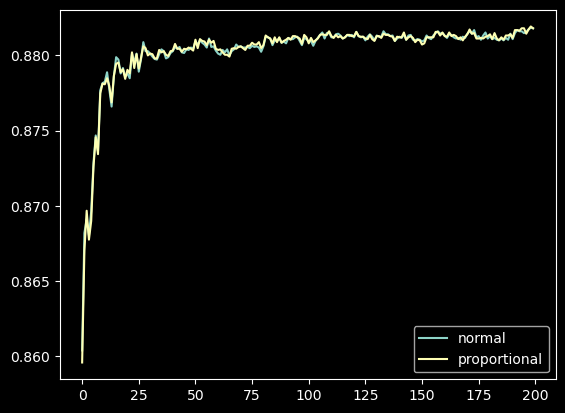

In [12]:
trainData = load_imdb("./data/imdb/train_labeledBow.feat")
testData = load_imdb("./data/imdb/test_labeledBow.feat")

compare(testData, trainData, "IMDB", 200, vectorize=True)

#### cod RNA
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#cod-rna

Dataset: cod RNA
Train size: 59535
Test size: 271617
Features: 8
---------------------------
Adding:        0.8897 (epochs: 200)
Adding (prop): 0.8897 (epochs: 200)
perceptron:    0.6847 
svm:           0.9207 


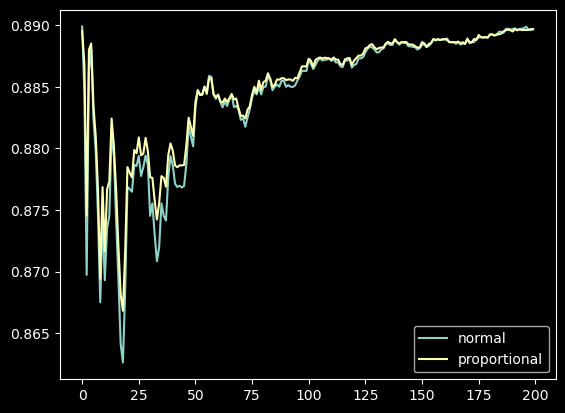

In [6]:
testData = load_data("./data/cod-rna/test.txt")
trainData = load_data("./data/cod-rna/train.txt")

compare(testData, trainData, "cod RNA", 200)

#### cov type
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#covtype.binary 

Dataset: covtype
Train size: 116202
Test size: 464810
Features: 54
---------------------------
Adding:        0.6052 (epochs: 300)
Adding (prop): 0.6043 (epochs: 300)
perceptron:    0.5052 
svm:           0.5581 


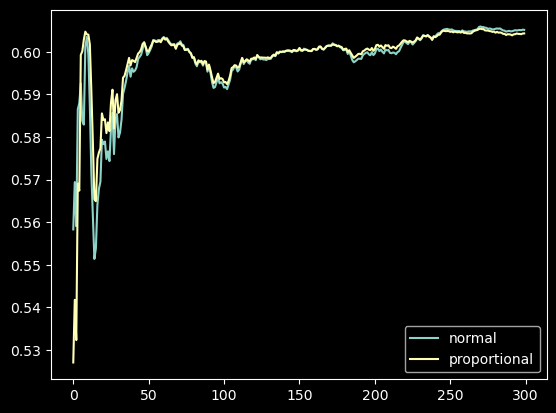

In [11]:
data = load_data("./data/cov/covtype.libsvm.binary")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.8)

compare((test_X, test_y), (X, y), "covtype", 300)

#### Webspam
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#webspam

Dataset: webspam
Train size: 175000
Test size: 175000
Features: 254
---------------------------
Adding:        0.9267 (epochs: 100)
Adding (prop): 0.9267 (epochs: 100)
perceptron:    0.9207 
svm:           0.9256 


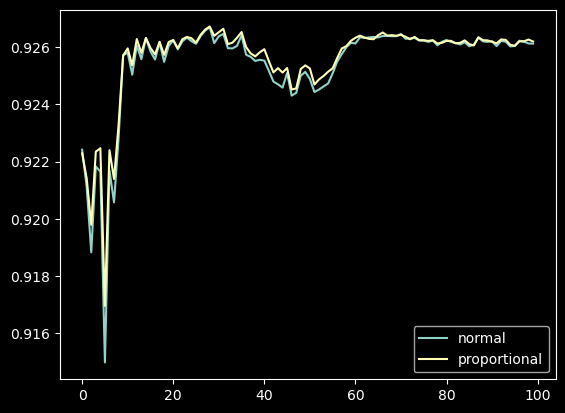

In [8]:
data = load_data("./data/webspam/unigram.svm")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.5)

compare((test_X, test_y), (X, y), "webspam", 100)

#### Poker
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#poker 
(10 classes)

Dataset: poker
Train size: 25010
Test size: 1000000
Features: 10
---------------------------
Adding:        0.5016 (epochs: 100)
Adding (prop): 0.5015 (epochs: 100)
perceptron:    0.4110 
svm:           0.4614 


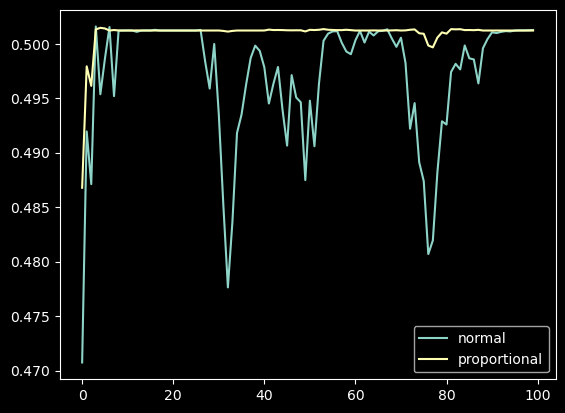

In [7]:
testData = load_data("./data/poker/poker.t")
trainData = load_data("./data/poker/poker")

compare(testData, trainData, "poker", 100)

#### real-sim
https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#real-sim 

Dataset: real-sim
Train size: 36154
Test size: 36155
Features: 20958
---------------------------
Adding:        0.9726 (epochs: 300)
Adding (prop): 0.9726 (epochs: 300)
perceptron:    0.9622 
svm:           0.9719 


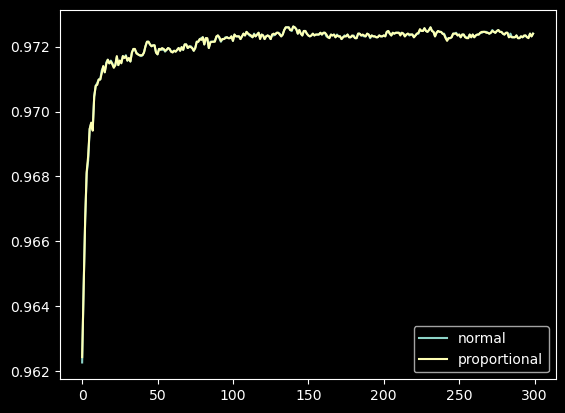

In [51]:
data = load_data("./data/real-sim/real-sim")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.5)

compare((test_X, test_y), (X, y), "real-sim", 300)

#### rcv binary

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#rcv1.binary

Dataset: rcv
Train size: 20242
Test size: 677399
Features: 47236
---------------------------
Adding:        0.9613 (epochs: 200)
Adding (prop): 0.9613 (epochs: 200)
perceptron:    0.9498 
svm:           0.9623 


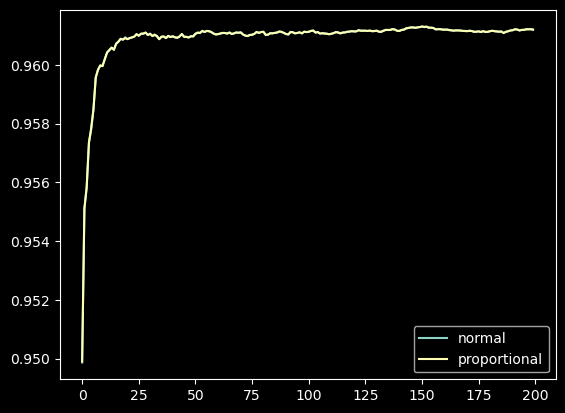

In [57]:
testData = load_data("./data/rcv/rcv1_test.binary")
trainData = load_data("./data/rcv/rcv1_train.binary")

compare(testData, trainData, "rcv", 200)

#### german.numer

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#german.numer

Dataset: german.numer
Train size: 900
Test size: 100
Features: 24
---------------------------
Adding:        0.7500 (epochs: 200)
Adding (prop): 0.7100 (epochs: 200)
perceptron:    0.7600 
svm:           0.7100 


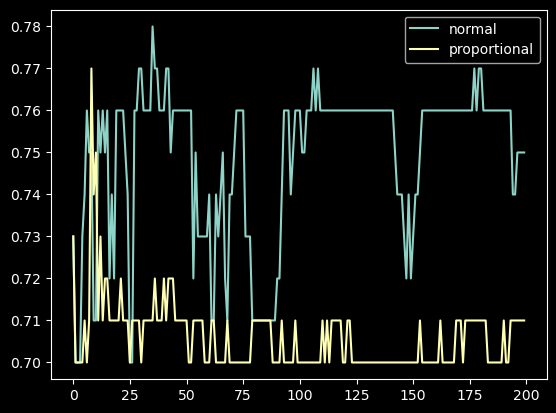

In [23]:
data = load_data("./data/german/german.numer")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.1)

compare((test_X, test_y), (X, y), "german.numer", 200)

#### ijcnn

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#ijcnn1

Dataset: ijcnn
Train size: 49990
Test size: 91701
Features: 22
---------------------------
Adding:        0.9235 (epochs: 200)
Adding (prop): 0.9233 (epochs: 200)
perceptron:    0.8973 
svm:           0.9178 


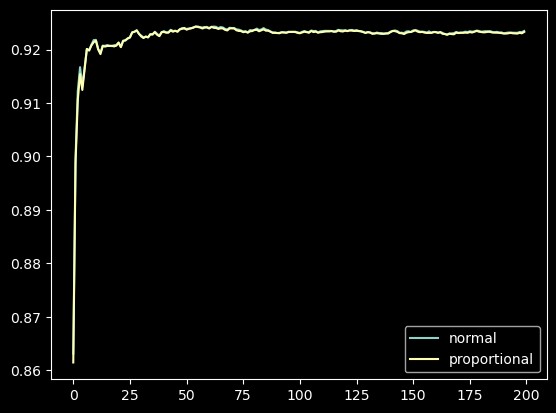

In [37]:
testData = load_data("./data/ijcnn/ijcnn1.t")
trainData = load_data("./data/ijcnn/ijcnn1")

compare(testData, trainData, "ijcnn", 200)

#### phishing

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#phishing

Dataset: phishing
Train size: 8844
Test size: 2211
Features: 68
---------------------------
Adding:        0.9430 (epochs: 200)
Adding (prop): 0.9421 (epochs: 200)
perceptron:    0.9340 
svm:           0.9426 


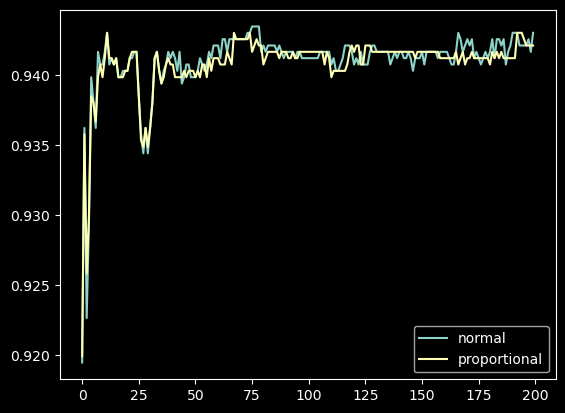

In [27]:
data = load_data("./data/phishing/phishing.txt")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.2)

compare((test_X, test_y), (X, y), "phishing", 200)

#### skin_nonskin

https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#skin_nonskin

Dataset: skin_nonskin
Train size: 196045
Test size: 49012
Features: 3
---------------------------
Adding:        0.8866 (epochs: 300)
Adding (prop): 0.8863 (epochs: 300)
perceptron:    0.9169 
svm:           0.7878 


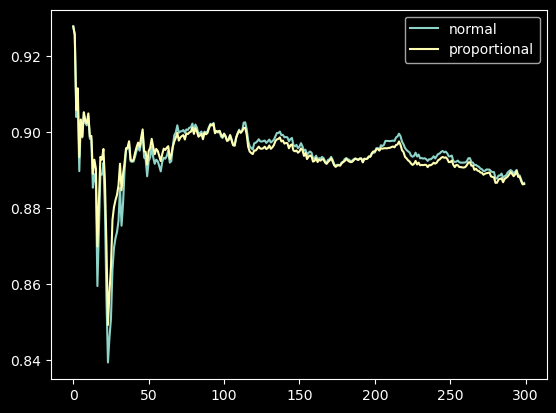

In [9]:
data = load_data("./data/skin/skin_nonskin.txt")
X, test_X, y, test_y = train_test_split(data[0], data[1], test_size=0.2)

compare((test_X, test_y), (X, y), "skin_nonskin", 300)

## Analysis

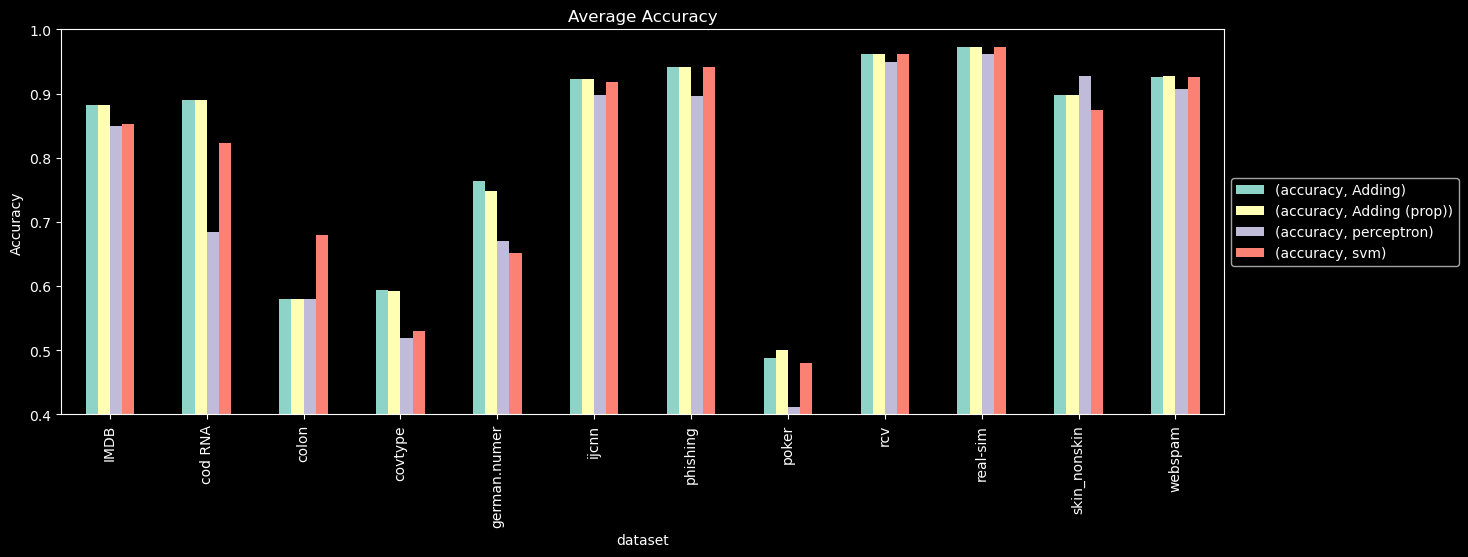

In [13]:
def get_averages(df: pd.DataFrame):
    df = df[
        list((s["epochs"] < 0 or s["epochs"] > 90) for _, s in df.iterrows())
    ]  # remove adding runs < 90 epochs (<1 is the other models)
    df = df.drop("epochs", axis=1)
    return df.groupby(["dataset", "model"]).mean()


df = pd.read_csv("results.csv", index_col=[0, 1])
means = get_averages(df)

means.unstack().plot(kind="bar", figsize=(15, 5), ylabel="Accuracy", title="Average Accuracy")
leg = plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
lim = plt.ylim(0.4, 1)
plt.show()